In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fft2, ifft2
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import time
import random
from scipy.ndimage import gaussian_filter
from typing import Tuple, List, Optional


In [ ]:

class Matern2DGenerator:
    def __init__(self, nx=128, ny=128, dx=10.0, dy=10.0, seed=None, normalize_range=(0.01, 1.0)):
        """
        Anisotropic Matérn (von Karman) 2D random field generator.
        """
        self.nx = nx
        self.ny = ny
        self.dx = dx
        self.dy = dy
        self.normalize_range = normalize_range
        self.y_uniform = np.linspace(0, (ny - 1) * dy, ny)  # Uniform grid along depth
        self.seed = seed

    def generate_single(self, Lx, Ly, nu, num):
        """
        Generate a single anisotropic Matérn random field and normalize to the specified range.
        :param Lx, Ly: Correlation lengths in x and y directions (meters)
        :param nu: Smoothing parameter (>0)
        :param num: Nonlinear enhancement multiplier
        :return: field (nx, ny)
        """
        # Frequency grids (angular frequency)
        kx = fftfreq(self.nx, d=self.dx) * 2 * np.pi  # shape: (nx,)
        ky = fftfreq(self.ny, d=self.dy) * 2 * np.pi  # shape: (ny,)
        kx, ky = np.meshgrid(kx, ky, indexing='ij')   # shape: (nx, ny)
        k2 = kx**2 + ky**2

        # Anisotropic PSD: Treat Lx, Ly separately
        psd = ((Lx * kx)**2 + (Ly * ky)**2 + 1.0) ** (-(nu + 1.0))
        rng = np.random.default_rng(self.seed)

        # Complex Gaussian white noise
        noise = rng.normal(size=(self.nx, self.ny)) + 1j * rng.normal(size=(self.nx, self.ny))

        # Frequency domain filtering
        filtered = noise * np.sqrt(psd)

        # IFFT and take real part
        field = np.real(ifft2(filtered))

        # Normalize to zero-mean and unit variance (optional, for stability)
        field = (field - field.mean()) / field.std()

        # Nonlinear enhancement: emphasize medium-gradient areas
        field = np.tanh(num * field)

        # Rescale to [set_lower, set_upper]
        set_lower, set_upper = self.normalize_range
        f_min, f_max = field.min(), field.max()
        if f_max - f_min > 1e-12:
            field = (set_upper - set_lower) * (field - f_min) / (f_max - f_min) + set_lower
        else:
            field = np.full_like(field, (set_lower + set_upper) / 2)

        return field

    def generate_complex(self, *scales_groups, num=1):
        """
        Generate a multi-scale, optionally multi-smoothness Matérn-like random field and normalize to the specified range.
        :param scales_groups: Take several [(Lx, Ly, nu), ...] lists, each group containing multiple triplets
        :param num: Nonlinear enhancement multiplier for each component
        :return: field (nx, ny), z_log (log-depth array)
        """
        fields = []
        for scales_list in scales_groups:
            for triple in scales_list:
                if len(triple) != 3:
                    raise ValueError("Each element in scales_list must be (Lx, Ly, nu) triplet.")
                Lx, Ly, nu = triple
                field = self.generate_single(Lx=Lx, Ly=Ly, nu=nu, num=num)
                fields.append(field)

        if not fields:
            raise ValueError("No valid scale parameters provided for random field generation.")

        summed_field = sum(fields) / len(scales_groups)
        # Normalize again to the specified range
        set_lower, set_upper = self.normalize_range
        f_min, f_max = summed_field.min(), summed_field.max()
        if f_max - f_min > 1e-12:
            summed_field = (set_upper - set_lower) * (summed_field - f_min) / (f_max - f_min) + set_lower
        else:
            summed_field = np.full_like(summed_field, (set_lower + set_upper) / 2)

        z_log = self.create_log_depth_grid()

        return summed_field, z_log

    def create_log_depth_grid(self, z0=1.0, exponent=2.5):
        """
        Create log-spaced depth grid centers (for interpolation).
        :param z0: Controls near-surface resolution
        :param exponent: Controls increase rate (higher = sparser in deep regions)
        :return: z_log (nz,)
        """
        y_max = self.y_uniform[-1]
        i = np.linspace(0, 1, self.ny + 1)
        z_edges = z0 * (np.exp(exponent * i) - 1)
        z_edges = z_edges / z_edges[-1] * y_max
        z_centers = (z_edges[:-1] + z_edges[1:]) / 2

        return z_centers

    def stitching_artifact(self, rho_log, z_log, depth_perturb_strength=0.1):
        """
        Simulate stripe artifacts caused by conventional 1D inversion stitching.
        :param rho_log: (nx, nz) resistivity model on log-depth grid
        :param z_log: (nz,) true depth array (monotonically increasing)
        :param depth_perturb_strength: Relative strength of depth perturbation (to total depth)
        :return: rho_perturbed (nx, nz)
        """
        nx, nz = self.nx, self.ny
        z_max = z_log[-1]
        rho_perturbed = np.empty_like(rho_log)
        rng = np.random.default_rng(self.seed)

        for i in range(nx):
            # For each column, generate an independent depth perturbation function (simulate 1D inversion error)
            # Approach: superimpose a smooth random perturbation on true depth
            noise = rng.normal(size=nz)
            # Smooth perturbation (avoid high-frequency oscillation)
            smooth_noise = gaussian_filter1d(noise, sigma=2.5)
            perturb = depth_perturb_strength * z_max * smooth_noise

            # Estimated depth
            z_est = z_log + perturb
            # Force monotonicity
            z_est = np.maximum.accumulate(z_est)
            # Avoid repeated depths
            z_est = np.clip(z_est, z_log[0], z_max)

            rho_perturbed[i, :] = np.interp(z_log, z_est, rho_log[i, :], left=rho_log[i, 0], right=rho_log[i, -1])

        return rho_perturbed


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25072\955523171.py:101: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


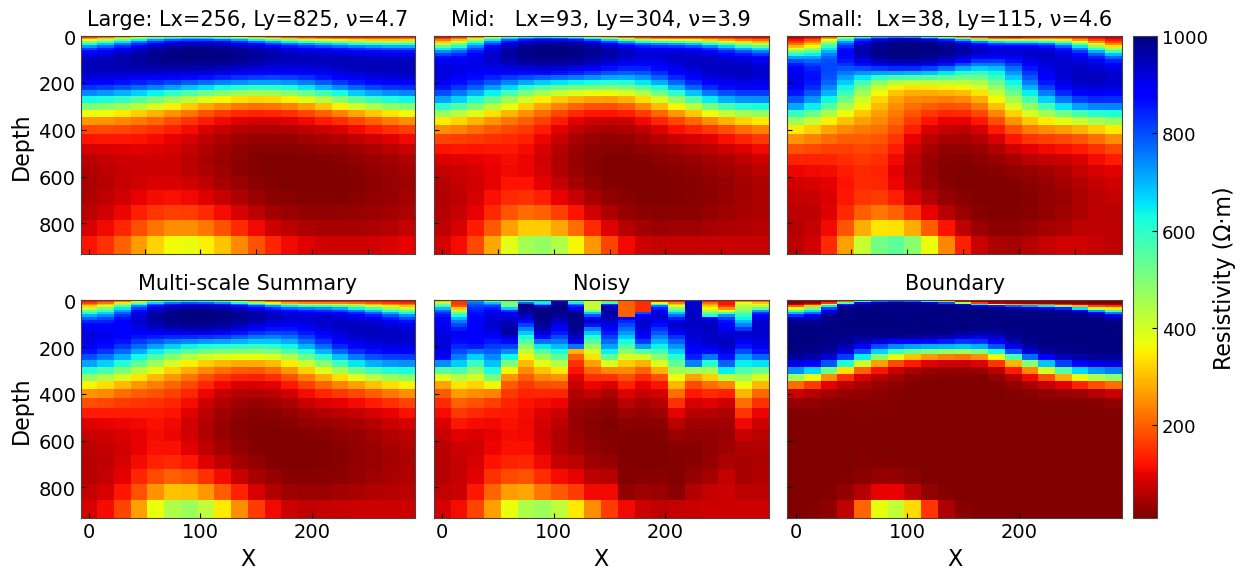

In [ ]:
nx = 20
ny = 32
dx = 15
dy = 30
normalize_range = (10, 1000)
Lx = nx * dx
Ly = ny * dy

import time
random_seed = int(time.time())
gen = Matern2DGenerator(nx, ny, dx, dy, seed=random_seed, normalize_range=normalize_range)

# Multi-scale configuration: (Lx, Ly, nu)
Lx = nx * dx
Ly = ny * dy

scales_large = [(random.randint(Lx // 2, Lx // 1), random.randint(Ly // 2, Ly // 1), np.random.uniform(3, 5))]
scales_mid = [(random.randint(Lx // 5, Lx // 3), random.randint(Ly // 5, Ly // 3), np.random.uniform(3, 5))]
scales_fine = [(random.randint(Lx // 9, Lx // 7), random.randint(Ly // 9, Ly // 7), np.random.uniform(3, 5))]

# Generate three components for multi-scale fields separately
fields = [
    gen.generate_single(Lx=l, Ly=k, nu=n, num=1) for l, k, n in scales_large + scales_mid + scales_fine
]

summed_field, z_log = gen.generate_complex(scales_large, scales_mid, scales_fine, num=1)
summed_field_stitching_artifact = gen.stitching_artifact(summed_field, z_log)
summed_field_boundary, z_log = gen.generate_complex(scales_large, scales_mid, scales_fine, num=3)

# Visualization - beautified version
import matplotlib
from matplotlib import ticker

plt.rcParams.update({
    'font.size': 13,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.edgecolor': '#444444'
})

fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True, dpi=100)

def pretty_tuple(triple):
    return f"Lx={triple[0]}, Ly={triple[1]}, ν={triple[2]:.1f}"

titles = [
    f"Large: {pretty_tuple(scales_large[0])}",
    f"Mid:   {pretty_tuple(scales_mid[0])}",
    f"Small:  {pretty_tuple(scales_fine[0])}",
    "Multi-scale Summary",
    "Noisy",
    "Boundary",
]

axes_flat = axes.flatten()

for idx, (ax, f, title) in enumerate(zip(axes_flat, fields + [summed_field] + [summed_field_stitching_artifact] + [summed_field_boundary], titles)):
    # Construct meshgrid for X and Y to plot X,Y coordinates
    x = np.arange(0, nx * dx, dx)
    y = z_log
    X, Y = np.meshgrid(x, y.T, indexing='ij')
    
    im = ax.pcolormesh(X, Y, f, cmap='jet_r')
    ax.set_title(title, pad=8)
    
    # Beautify ticks and labels
    row, col = divmod(idx, 3)
    if row == 0:
        ax.set_xlabel("")                    # Do not show X label on the first row
        ax.xaxis.set_ticklabels([])          # Hide x-axis tick labels as well
    else:
        ax.set_xlabel("X", fontsize=16)
        ax.xaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_visible(True)

    if col == 0:
        ax.set_ylabel("Depth", fontsize=16)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_visible(True)
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])          # Hide y-axis ticks for columns 2-3
        ax.yaxis.set_visible(True)

    ax.invert_yaxis()
# Layout optimization for display
fig.tight_layout()

# Single common colorbar
cbar = fig.colorbar(im, ax=axes, fraction=0.035, pad=0.01)
cbar.set_label('Resistivity (Ω·m)', fontsize=16)  # Set colorbar label font size

plt.show()


## batch

In [195]:
batch_num =12000
clean = []
noisy = []
mask = []

In [ ]:
nx=16
ny=32
dx=15
dy=15
normalize_range =(1,6000)
Lx = nx*dx
Ly = ny*dy



for i in range(batch_num):
    gen = Matern2DGenerator(nx, ny, dx, dy, seed=np.random.randint(0, 1000000), normalize_range=normalize_range)

    scales_large = [(random.randint(Lx//2, Lx//1), random.randint(Ly//2, Ly//1), np.random.uniform(3, 5))]
    scales_mid = [(random.randint(Lx//5, Lx//3), random.randint(Ly//5, Ly//3),  np.random.uniform(3, 5))]
    scales_fine = [(random.randint(Lx//9, Lx//7), random.randint(Ly//9, Ly//7),  np.random.uniform(3, 5))]

    field, z_log =gen.generate_complex(scales_large,scales_mid,scales_fine,num=1) 
    field_stitching_artifact = gen.stitching_artifact(field, z_log,depth_perturb_strength=np.random.uniform(0.05,0.2))
    field_mask, z_log =gen.generate_complex(scales_large,scales_mid,scales_fine,num=3) 


    clean.append(field)

    noisy.append(field_stitching_artifact)

    mask.append(field_mask)


In [197]:
'''train_x = np.array(np.array(noisy))
train_y = np.array(np.array(clean))
train_mask = np.array(np.array(mask))

np.save('train_x.npy', train_x)
np.save('train_y.npy', train_y)
np.save('train_mask.npy', train_mask)'''

"train_x = np.array(np.array(noisy))\ntrain_y = np.array(np.array(clean))\ntrain_mask = np.array(np.array(mask))\n\nnp.save('train_x.npy', train_x)\nnp.save('train_y.npy', train_y)\nnp.save('train_mask.npy', train_mask)"